#  Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
from tensorflow.keras import Model , layers, Sequential
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random
from sklearn.model_selection import train_test_split

In [2]:
tf.config.list_physical_devices('GPU')

tf.keras.backend.clear_session()
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Dataset


In [6]:
IMG_SIZE = 128
MASK_SIZE = 32
def random_mask(image, n=1):
    image = tf.image.convert_image_dtype(image, tf.float32)
    h, w, _ = image.shape
    masked_image = image

    for _ in range(n):
        top = tf.random.uniform([], 0, h - MASK_SIZE, dtype=tf.int32)
        left = tf.random.uniform([], 0, w - MASK_SIZE, dtype=tf.int32)

        mask = tf.ones((MASK_SIZE, MASK_SIZE, 3))
        paddings = [[top, h - top - MASK_SIZE], [left, w - left - MASK_SIZE], [0, 0]]
        mask = tf.pad(mask, paddings, constant_values=0)

        masked_image = masked_image * (1.0 - mask)

    return masked_image, image  # input con huecos, target original

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/train",
    labels=None,
    batch_size=64,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/test",
    labels=None,
    batch_size=64,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/val",
    labels=None,
    batch_size=64,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

train_dataset_ssl = train_dataset.map(lambda x: tf.map_fn(lambda img: random_mask(img, n=4), x, dtype=(tf.float32, tf.float32)))
test_dataset_ssl = test_dataset.map(lambda x: tf.map_fn(lambda img: random_mask(img, n=4), x, dtype=(tf.float32, tf.float32)))
val_dataset_ssl = val_dataset.map(lambda x: tf.map_fn(lambda img: random_mask(img, n=4), x, dtype=(tf.float32, tf.float32)))


normalization_layer = tf.keras.layers.Rescaling(1./255)


train_dataset_ssl = train_dataset_ssl.map(lambda x, y: (normalization_layer(x), normalization_layer(y)))
test_dataset_ssl = test_dataset_ssl.map(lambda x, y: (normalization_layer(x), normalization_layer(y)))
val_dataset_ssl = val_dataset_ssl.map(lambda x, y: (normalization_layer(x), normalization_layer(y)))

train_dataset_ssl.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset_ssl.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset_ssl.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)

Found 20300 files belonging to 1 classes.
Found 5800 files belonging to 1 classes.
Found 2900 files belonging to 1 classes.


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 128, 128, 3), dtype=tf.float32, name=None))>

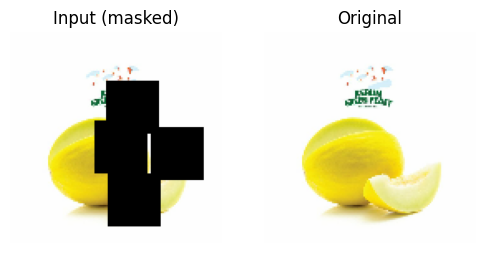

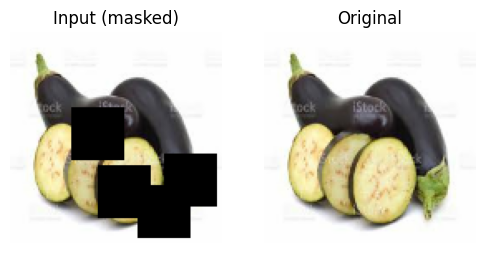

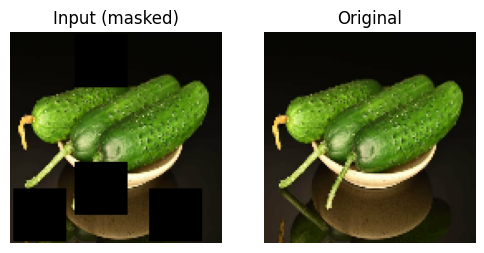

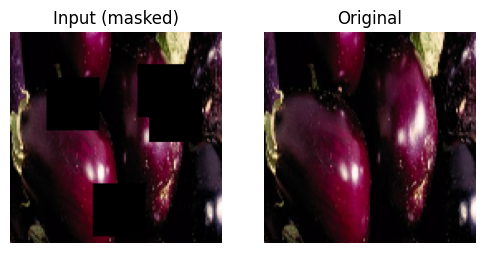

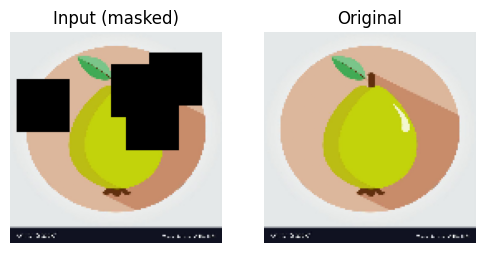

In [12]:
# Visualize the first images in the train_dataset_ssl
for images_gray, images_real in train_dataset_ssl.take(1):
    for i in range(5):  # Display the first 5 images
        plt.figure(figsize=(6, 3))

        plt.subplot(1, 2, 1)
        plt.imshow(images_gray[i])
        plt.title("Input (masked)")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(images_real[i])
        plt.title("Original")
        plt.axis("off")

        plt.show()

In [13]:
def unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, 3, activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = layers.Conv2D(1024, 3, activation="relu", padding="same")(p4)
    bn = layers.Conv2D(1024, 3, activation="relu", padding="same")(bn)

    # Decoder
    u1 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding="same")(bn)
    u1 = layers.concatenate([u1, c4])
    c5 = layers.Conv2D(512, 3, activation="relu", padding="same")(u1)
    c5 = layers.Conv2D(512, 3, activation="relu", padding="same")(c5)

    u2 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding="same")(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = layers.Conv2D(256, 3, activation="relu", padding="same")(u2)
    c6 = layers.Conv2D(256, 3, activation="relu", padding="same")(c6)

    u3 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding="same")(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = layers.Conv2D(128, 3, activation="relu", padding="same")(u3)
    c7 = layers.Conv2D(128, 3, activation="relu", padding="same")(c7)

    u4 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding="same")(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = layers.Conv2D(64, 3, activation="relu", padding="same")(u4)
    c8 = layers.Conv2D(64, 3, activation="relu", padding="same")(c8)

    # Output: 3-channel RGB image with sigmoid (for [0,1] range)
    outputs = layers.Conv2D(3, 1, activation="sigmoid")(c8)

    return Model(inputs, outputs, name="U-Net_Colorization")


model = unet((128, 128, 3))
model.summary()

Model: "U-Net_Colorization"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                

In [14]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mse",metrics=["mae", psnr, ssim])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_unet_colorization.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1),
]
history = model.fit(
    train_dataset_ssl,  # tf.data.Dataset o generator
    verbose=1,  # Mostrar progreso
    validation_data=test_dataset_ssl,  # validación con rotaciones también
    epochs=50,
    batch_size=8,  # Puedes probar 64 o 128 según tu GPU
    callbacks=callbacks,
)


Epoch 1/50
318/318 [==============================] - 228s 612ms/step - loss: 0.0323 - mae: 0.1264 - psnr: 16.3515 - ssim: 0.5058 - val_loss: 0.0136 - val_mae: 0.0767 - val_psnr: 19.0025 - val_ssim: 0.6379 - lr: 1.0000e-04
Epoch 2/50
318/318 [==============================] - 186s 582ms/step - loss: 0.0113 - mae: 0.0662 - psnr: 19.9072 - ssim: 0.6783 - val_loss: 0.0104 - val_mae: 0.0633 - val_psnr: 20.1860 - val_ssim: 0.7115 - lr: 1.0000e-04
Epoch 3/50
318/318 [==============================] - 186s 584ms/step - loss: 0.0094 - mae: 0.0566 - psnr: 20.7487 - ssim: 0.7325 - val_loss: 0.0086 - val_mae: 0.0530 - val_psnr: 21.0821 - val_ssim: 0.7525 - lr: 1.0000e-04
Epoch 4/50
318/318 [==============================] - 186s 584ms/step - loss: 0.0084 - mae: 0.0512 - psnr: 21.2392 - ssim: 0.7609 - val_loss: 0.0077 - val_mae: 0.0470 - val_psnr: 21.5979 - val_ssim: 0.7743 - lr: 1.0000e-04
Epoch 5/50
318/318 [==============================] - 186s 583ms/step - loss: 0.0077 - mae: 0.0471 - psnr: 2

<Figure size 1200x600 with 0 Axes>

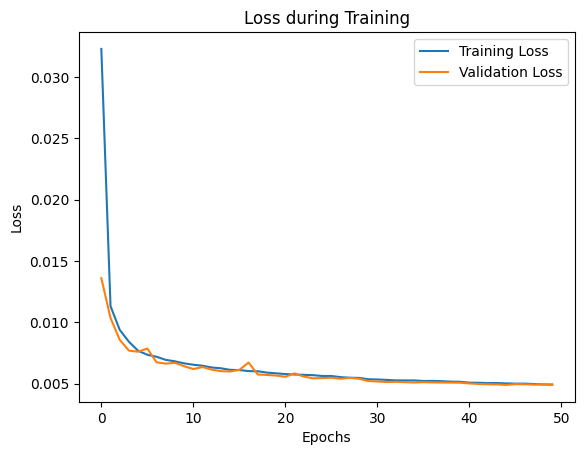

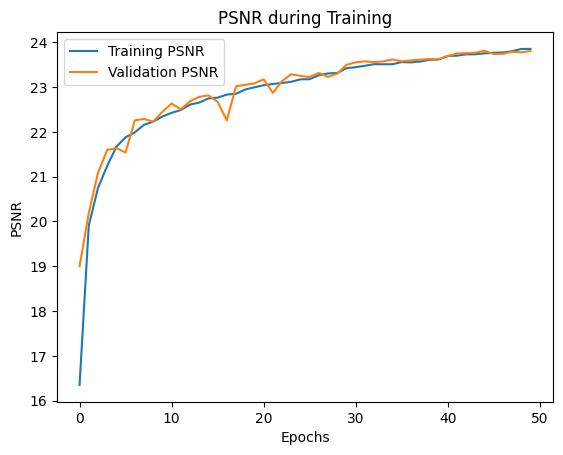

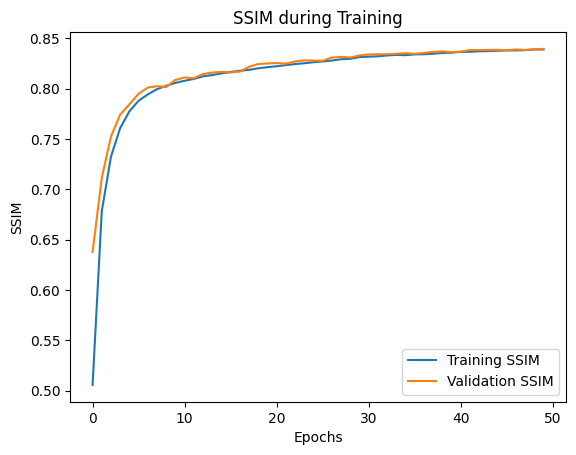

In [17]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # PSNR
    plt.figure()
    plt.plot(history.history['psnr'], label='Training PSNR')
    plt.plot(history.history['val_psnr'], label='Validation PSNR')
    plt.title('PSNR during Training')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR')
    plt.legend()
    plt.show()

    # SSIM
    plt.figure()
    plt.plot(history.history['ssim'], label='Training SSIM')
    plt.plot(history.history['val_ssim'], label='Validation SSIM')
    plt.title('SSIM during Training')
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.legend()
    plt.show()

# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)

2/2 [==============================] - 0s 288ms/step


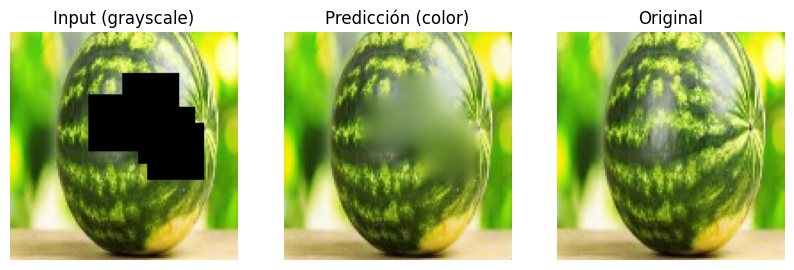

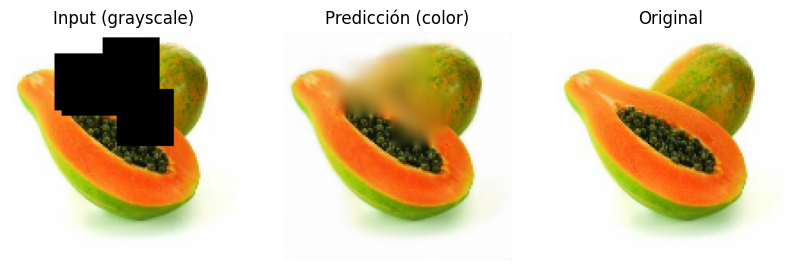

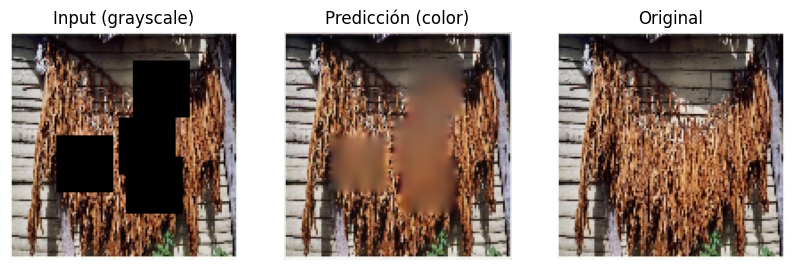

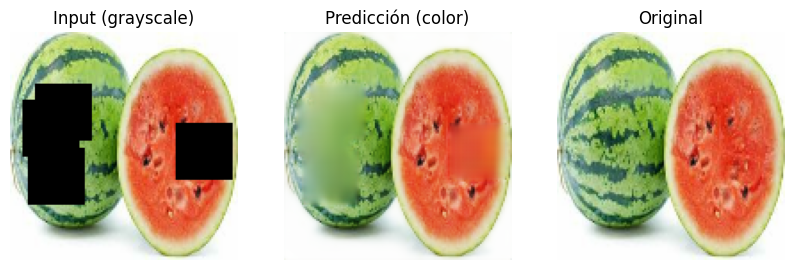

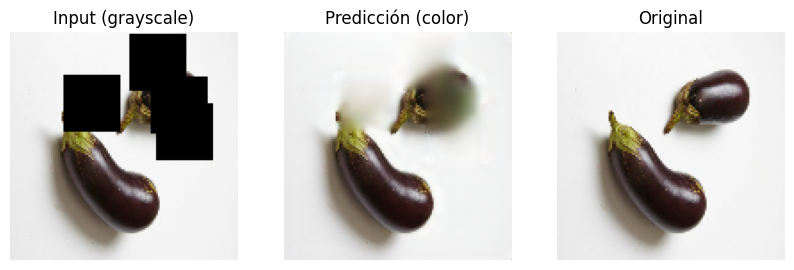

In [29]:
def show_colorization_examples(dataset, model, n=5):
    for images_gray, images_real in dataset.take(1):
        preds = model.predict(images_gray)

        for i in range(n):
            plt.figure(figsize=(10, 3))

            plt.subplot(1, 3, 1)
            plt.imshow(images_gray[i])
            plt.title("Input (grayscale)")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(preds[i])
            plt.title("Predicción (color)")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(images_real[i])
            plt.title("Original")
            plt.axis("off")

            plt.show()
show_colorization_examples(val_dataset_ssl, model, n=5)

In [19]:
# encoder = tf.keras.Model(inputs=model.input, outputs=model.get_layer("name_of_encoder_output_layer").output)
#load model
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)
encoder = tf.keras.models.load_model(
	"best_unet_colorization.h5",
	custom_objects={"psnr": psnr, "ssim": ssim}
)
encoder.trainable = False  # congelar
# numero de cpapas
len(encoder.layers)

32

In [61]:
encoder_output = encoder.layers[14].output  # cuello en 13
encoder_model = Model(inputs=encoder.input, outputs=encoder_output, name="UNet_Encoder")
encoder_model.trainable = False  # congelar
#descongela las ultimas  4 capas
encoder_model.summary()


Model: "UNet_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                      

In [2]:
import tensorflow as tf

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/train',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(128, 128),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)



test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/test',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(128, 128),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/val',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(128, 128),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)


normalization_layer = tf.keras.layers.Rescaling(1./255)


# Normalización
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)



# Tamaño del dataset
train_size = tf.data.experimental.cardinality(train_dataset).numpy()
test_size = tf.data.experimental.cardinality(test_dataset).numpy()
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")
print(f"Validation size: {val_size}")


Found 20300 files belonging to 29 classes.
Found 5800 files belonging to 29 classes.
Found 2900 files belonging to 29 classes.
Train size: 318
Test size: 91
Validation size: 46


In [63]:
from tensorflow import keras
# 1️⃣ Define la entrada
inputs = tf.keras.Input(shape=(128, 128, 3))
x = encoder_model(inputs)
x = layers.LayerNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(29, activation='softmax')(x)

unet_clas = Model(inputs=inputs, outputs=outputs, name="UNet_Classifier")
unet_clas.summary()

Model: "UNet_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 UNet_Encoder (Functional)   (None, 8, 8, 1024)        18843200  
                                                                 
 layer_normalization_5 (Laye  (None, 8, 8, 1024)       2048      
 rNormalization)                                                 
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 1024)              1049600   
                                                                 
 batch_normalization_10 (Bat  (None, 1024)         

In [64]:
for x_batch, y_batch in train_dataset.take(1):
    print(x_batch.shape)  # (batch, 128, 128, 3)
    print(y_batch.shape)  # (batch, )
unet_clas.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath='best_modelUnet.h5', save_best_only=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.2, min_lr=1e-6),
]




history = unet_clas.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

(64, 128, 128, 3)
(64,)
Epoch 1/100
318/318 [==============================] - 41s 93ms/step - loss: 4.8498 - accuracy: 0.1932 - val_loss: 4.5460 - val_accuracy: 0.1997 - lr: 1.0000e-04
Epoch 2/100
318/318 [==============================] - 35s 78ms/step - loss: 4.2688 - accuracy: 0.2875 - val_loss: 3.8153 - val_accuracy: 0.3878 - lr: 1.0000e-04
Epoch 3/100
318/318 [==============================] - 35s 78ms/step - loss: 4.0069 - accuracy: 0.3379 - val_loss: 3.6370 - val_accuracy: 0.4271 - lr: 1.0000e-04
Epoch 4/100
318/318 [==============================] - 35s 79ms/step - loss: 3.7988 - accuracy: 0.3772 - val_loss: 3.5186 - val_accuracy: 0.4521 - lr: 1.0000e-04
Epoch 5/100
318/318 [==============================] - 35s 79ms/step - loss: 3.6329 - accuracy: 0.4077 - val_loss: 3.4341 - val_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 6/100
318/318 [==============================] - 34s 78ms/step - loss: 3.4868 - accuracy: 0.4363 - val_loss: 3.3113 - val_accuracy: 0.4929 - lr: 1.0000e-04
Epoc

<Figure size 1200x600 with 0 Axes>

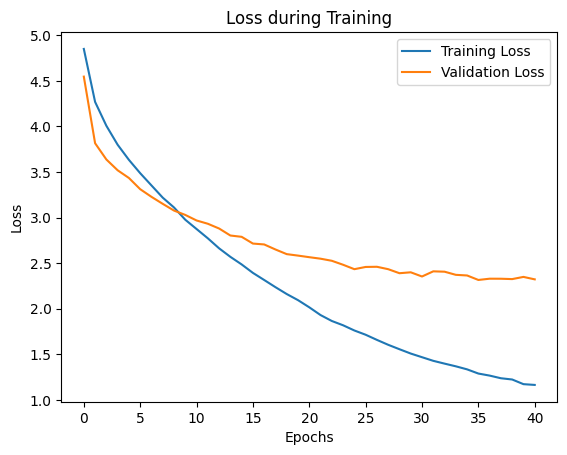

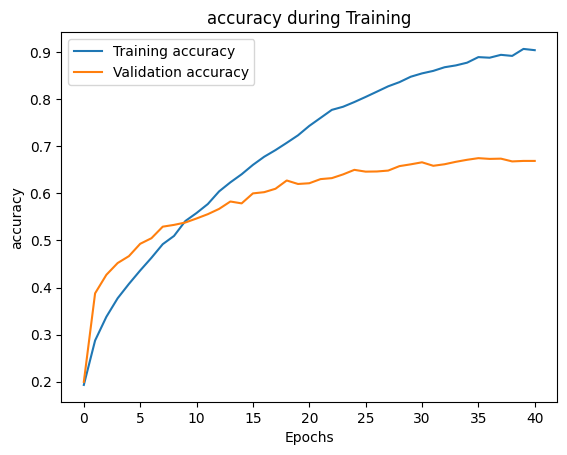

In [65]:
plt.figure(figsize=(12, 6))

# Pérdida
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# PSNR
plt.figure()
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


2/2 [==============================] - 1s 535ms/step
Accuracy de validación: 0.74


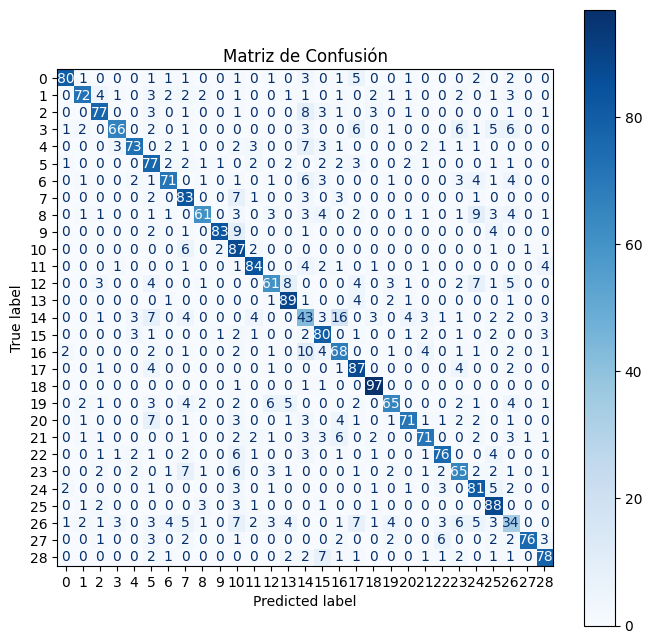

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import keras
#load the best model
# load
unet_clas = keras.models.load_model("best_modelUnet.h5")
# Load the best model with custom objects
# model_ = keras.models.load_model("best_modelV5.h5", custom_objects={"TFViTMAEMainLayer": TFViTMAEMainLayer})
# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = unet_clas.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
# elmina la etiqueta 3
# y_true = [label for label in y_true if label != 3]
# y_pred = [pred for pred, label in zip(y_pred, y_true) if label != 3]
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy de validación: {accuracy:.2f}")
# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(29))  # Ajusta el rango según tus clases
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title("Matriz de Confusión")
plt.show()

2/2 [==============================] - 0s 13ms/step


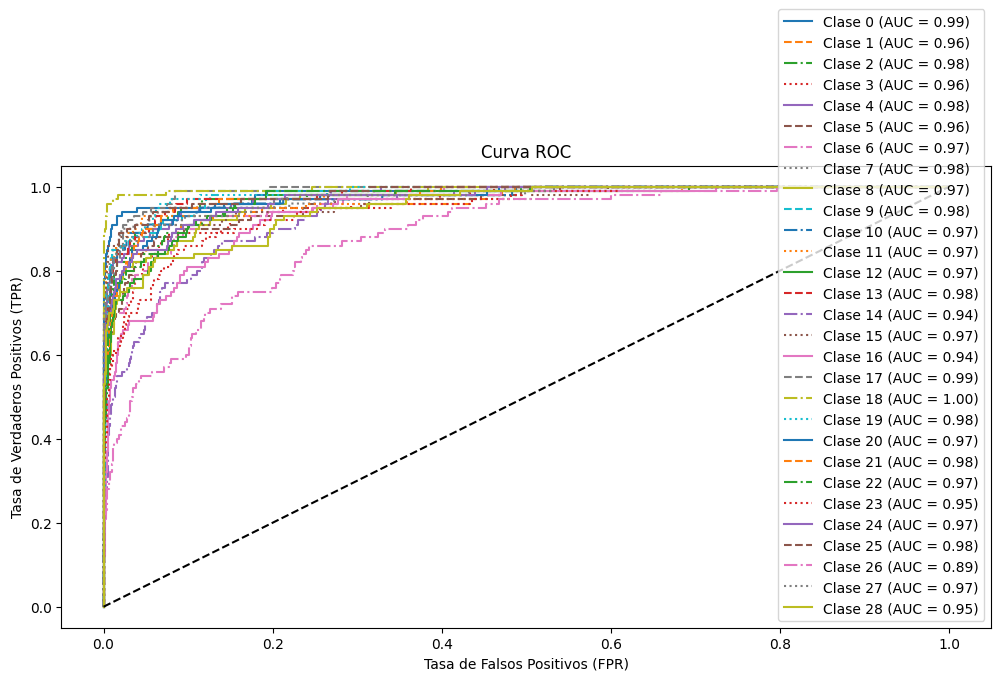

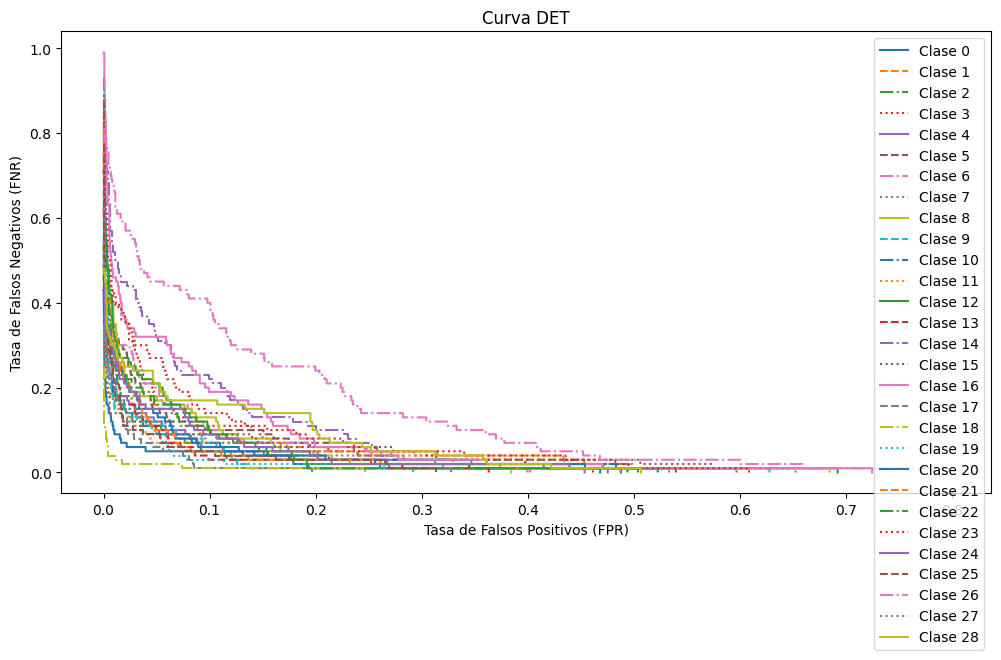

In [70]:
from sklearn.metrics import roc_curve, det_curve, auc

import matplotlib.pyplot as plt

# Convertir y_true y y_pred a formato binario para cada clase
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = unet_clas.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

y_true_binary = keras.utils.to_categorical(y_true, num_classes=29)
y_pred_binary = np.array(y_pred)

# Generar la curva ROC y calcular el AUC para cada clase
plt.figure(figsize=(12, 6))
line_styles = ['-', '--', '-.', ':']  # Diferentes estilos de línea
for i in range(29):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})', linestyle=line_styles[i % len(line_styles)])

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva DET para cada clase
plt.figure(figsize=(12, 6))
for i in range(29):
    # Verificar si hay más de una clase en y_true_binary[:, i]
    if len(np.unique(y_true_binary[:, i])) > 1:
        fpr, fnr, _ = det_curve(y_true_binary[:, i], y_pred_binary[:, i])
        plt.plot(fpr, fnr, label=f'Clase {i}', linestyle=line_styles[i % len(line_styles)])
    else:
        print(f"Clase {i} tiene solo una clase en y_true. No se puede generar la curva DET.")

plt.title('Curva DET')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Falsos Negativos (FNR)')
plt.legend(loc='upper right')
plt.show()